# Pipeline to predict popularity of a song on spotify based on 2022 data

In [1]:
import sys
sys.path.append(r'C:\Users\vanes\Git_repositories\Final_project_Arianna_Vanessa_Tatiana\spotify_library')
import spotify_library 
from spotify_library.preparation.data_loading import *
from spotify_library.preparation.EDA import *
from spotify_library.features.data_preprocessing import *
from spotify_library.features.feature_engineering import *
from spotify_library.modelling.data_splitting import *
from spotify_library.modelling.model import *

## Load the data

In [2]:
# load the spotify data of 2022 as df
df = loaddata(r'C:/Users/vanes/Git_repositories/Final_project_Arianna_Vanessa_Tatiana/reduced_spotify_2022.csv')

## Exploratory Data Analysis

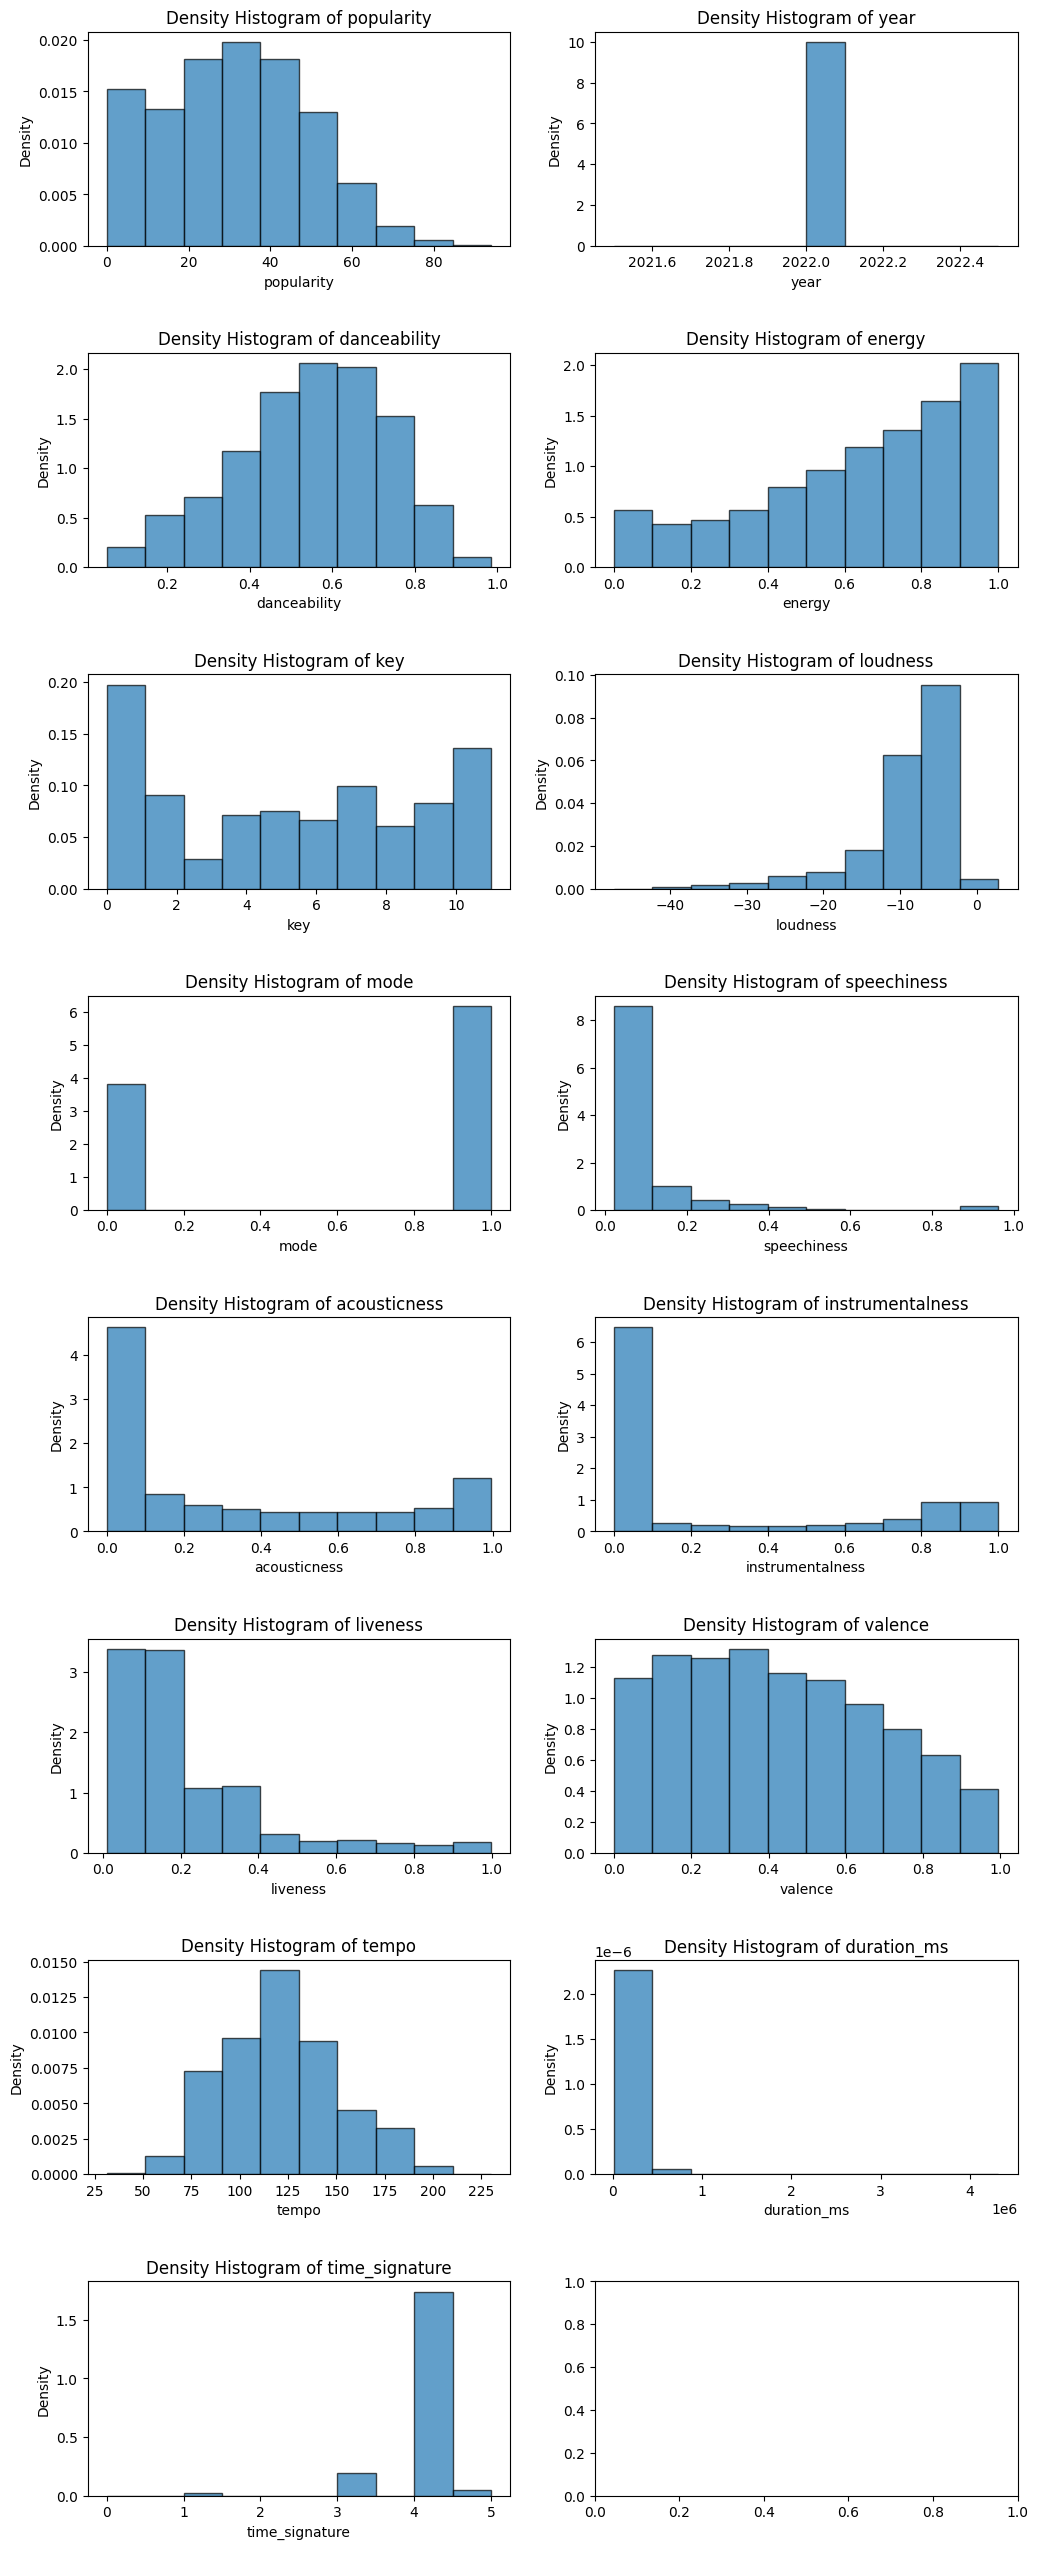

In [3]:
# plot histogram for numerical variables
columns = ['popularity', 'year', 'danceability', 'energy', 'key', 'loudness', 'mode',
           'speechiness', 'acousticness', 'instrumentalness', 'liveness',
           'valence', 'tempo', 'duration_ms', 'time_signature']
hist = plot_distribution(df, columns, bins=10, plots_per_row=2)

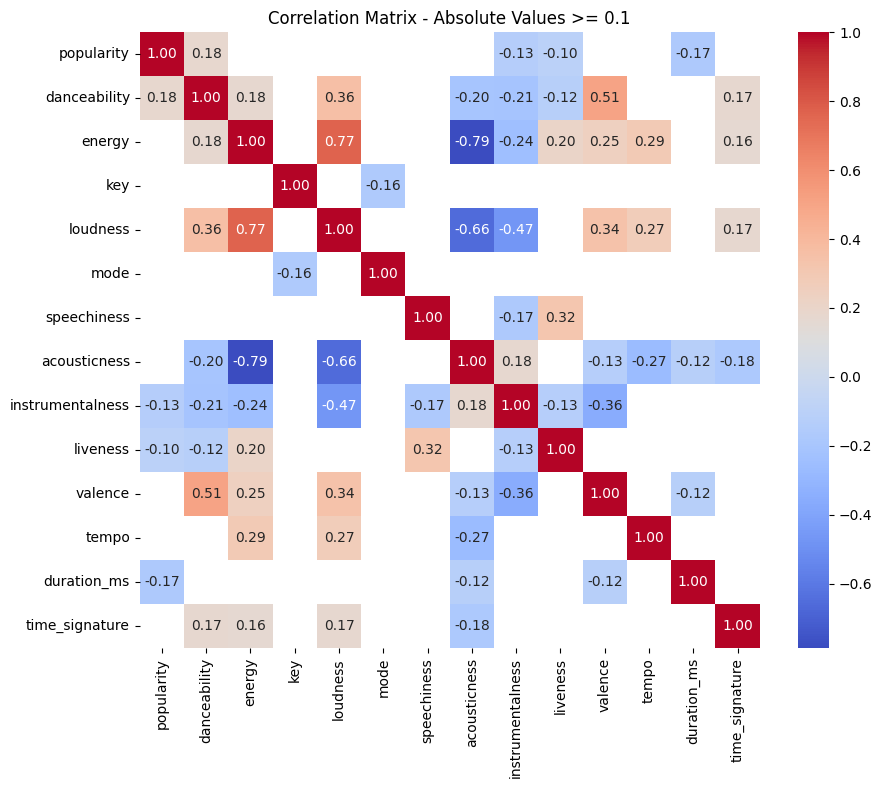

In [4]:
variables_list = ['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
                  'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                  'valence', 'tempo', 'duration_ms', 'time_signature']
corr = plot_correlation_heatmap(df, variables_list, threshold=0.1)

In [5]:
# Calculate unique counts for the specified columns
count = calculate_unique_counts(df, columns = ['track_name', 'artist_name', 'genre'])

Number of unique values in track_name: 49110
Number of unique values in artist_name: 12779
Number of unique values in genre: 82


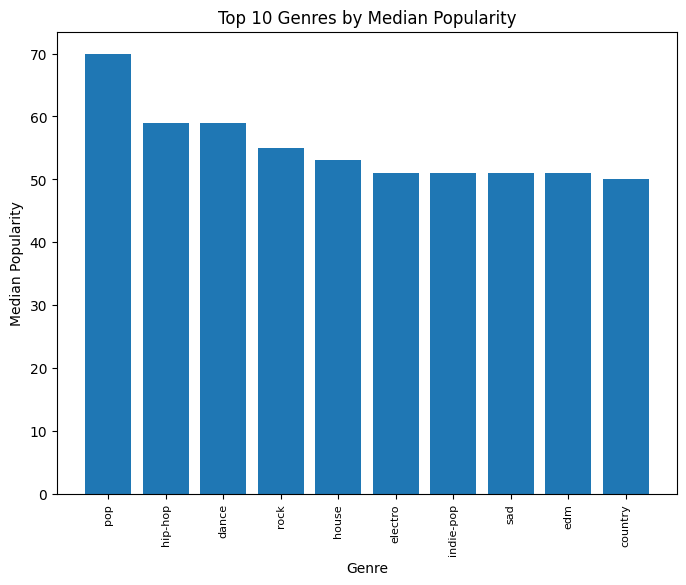

In [6]:
plot = bar_plot(df, 'genre', 'popularity', 'median', top_n=10)

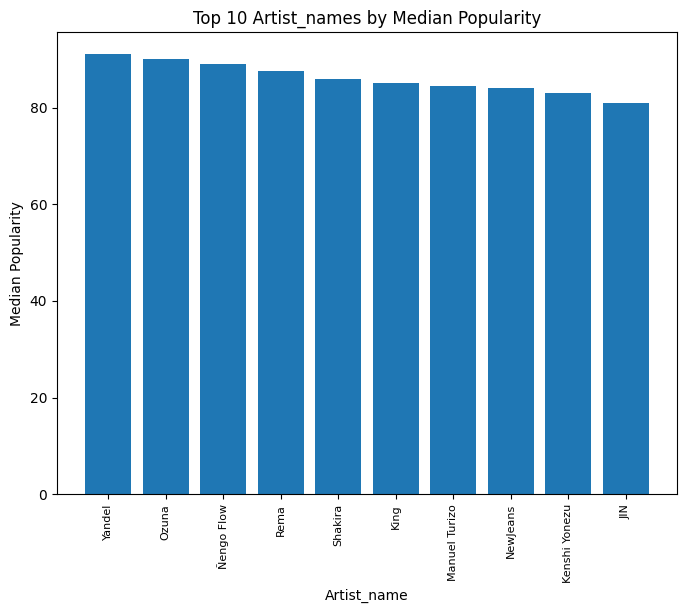

In [7]:
plot = bar_plot(df, 'artist_name', 'popularity', 'median', top_n=10)

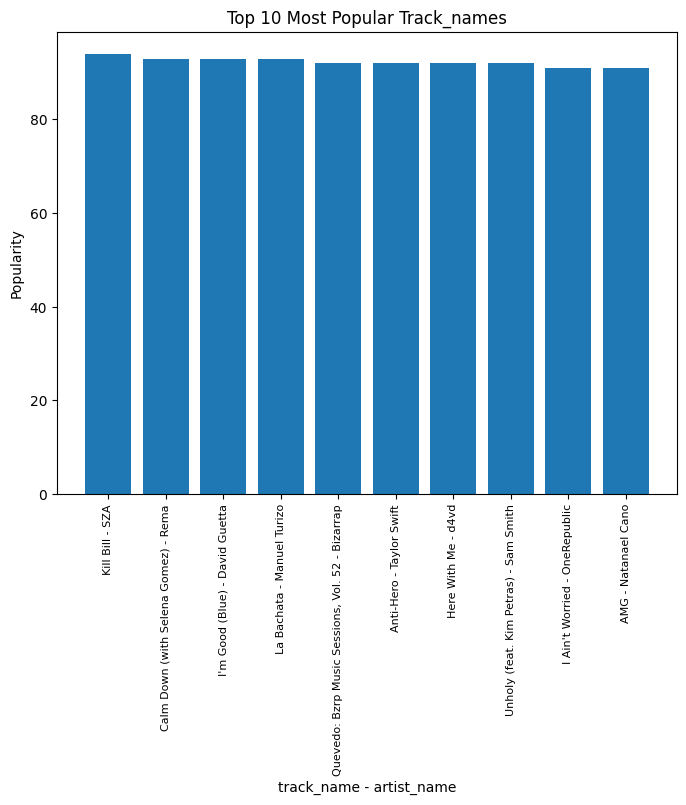

In [8]:
[*columns] = ['track_name', 'artist_name', 'popularity']
plot_top_items(df, 10, *columns)

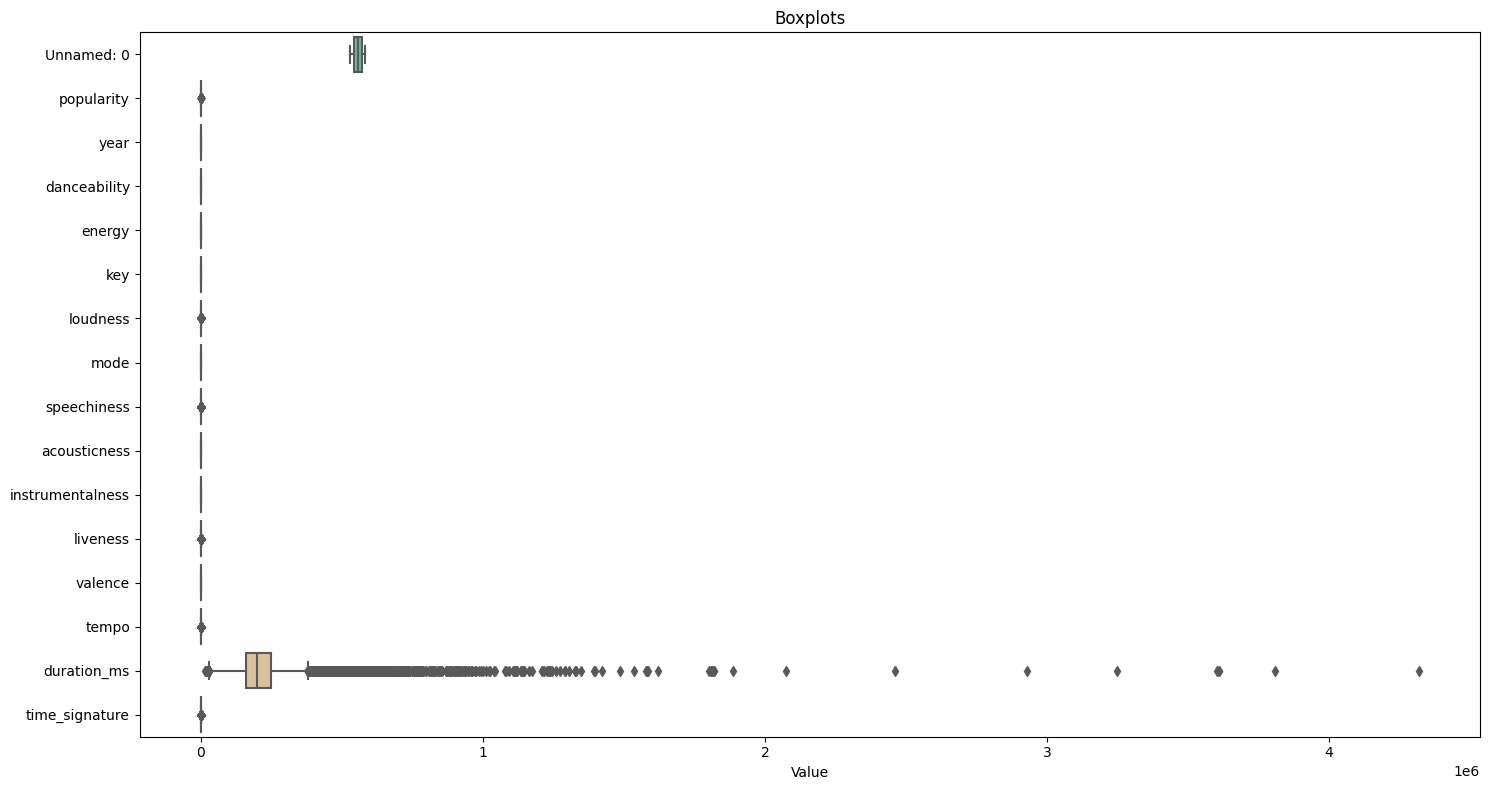

In [9]:
outliers = looking_for_outliers(df)

## Data Prepsocessing and Feature Generation

In [10]:
# check missing values
missing_data = missing_values_table(df)

Dataframe has 20 columns.
There are 0 columns that have missing values.


In [11]:
# drop unnecessary columns: track_id and Unnamed: 0
df = drop_columns(data = df, columns_to_drop=['track_id', 'Unnamed: 0'])

In [12]:
# transform column duration_ms to a column where the duration is in minutes
df = transform_ms_to_minutes(df, 'duration_ms')

In [13]:
# Create dummy variables for 'genre'
# For regression we will not need to add 'genre' as a feature
df = one_hot(df, 'genre')

In [14]:
# Execute target encoding for the column 'artist_name'
df = add_mean_column(df, 'artist_name', 'speechiness', 'mean_speechiness')

In [15]:
# because of the assumption that popularity is higher when the songs are also played in bars and clubs a variable will be invented: party_music
df = add_party_music_column(df)

In [16]:
# since we cannot include the track name in the model, we want to create a columns that captures whether the track name contains certain keywords

# Tokenize and count the words in a 'track_name' column
top_100_words = get_top_words(df, 'track_name', top_n=100)
print(top_100_words)


['-', ')', '(', 'the', '.', ',', 'of', 'you', 'remix', 'i', 'in', 'me', 'feat', 'a', 'live', 'to', 'love', 'my', 'vivo', 'it', "'s", 'ao', 'mix', 'version', ':', '&', 'for', 'on', 'do', 'de', '2022', 'and', 'from', 'no', "n't", 'up', 'with', "''", 'la', 'remastered', '/', '``', 'your', 'is', 'pt', 'at', 'all', 'time', 'be', 'hardstyle', 'we', '!', "'", 'edit', 'piano', 'like', 'one', 'night', '2', 'life', 'this', 'go', '[', ']', 'rain', '?', '’', 'out', 'en', 'good', 'el', 'that', 'what', 'back', 'let', '1', 'que', 'down', 'na', 'act', 'mixed', 'song', "'m", 'o', 'acoustic', 'take', 'sleep', 'sped', 'original', 'day', 'not', 'way', 'world', 'new', 'remaster', 'get', 'never', 'te', 'die', 'music']


In [17]:
# Manually get the list with the most popular meaningful words
words_list = ['remix', 'feat', 'live', 'love', 'my', 'vivo', 'mix', 'version', 'remastered', 'your', 'hardstyle', 'we', 'edit', 'piano', 'like', 'one', 'night', 'life', 'go', 'rain', 'good', 'let', 'mixed', 'acoustic', 'sleep', 'original', 'world', 'new', 'remaster', 'never', 'die']

In [18]:
# Create dummies with the value 1, if the value in the column 'track_name' contains phrase from the list 'words_list', and 0 otherwise
df = create_dummy_variables(df, 'track_name', words_list)

In [19]:
columns = words_list
calculate_value_counts(df, columns, top_n=10)

       remix  Count  Percentage
remix                          
0          0  51656   96.208001
1          1   2036    3.791999
      feat  Count  Percentage
feat                         
0        0  51967   96.787231
1        1   1725    3.212769
      live  Count  Percentage
live                         
0        0  52219   97.256575
1        1   1473    2.743425
      love  Count  Percentage
love                         
0        0  52368   97.534083
1        1   1324    2.465917
    my  Count  Percentage
my                       
0    0  52368   97.534083
1    1   1324    2.465917
      vivo  Count  Percentage
vivo                         
0        0  52576   97.921478
1        1   1116    2.078522
     mix  Count  Percentage
mix                        
0      0  50497   94.049393
1      1   3195    5.950607
         version  Count  Percentage
version                            
0              0  52779    98.29956
1              1    913     1.70044
            remastered  Count  P

In [20]:
# from EDA we could see, that some tracks are very long (more than 5 minnutes); we assume that these are tracks to sleep, meditate or relax generally
df = add_sleep_music_column(df)

In [21]:
# we want to include the effect of the length of a track name and therefore add a new variable for that
df = create_word_count_trackcolumn(df, 'track_name')

## Train the model

In [22]:
# split data into train and test data first
df_train, df_test = splitdata(df, 0.2, 40)

In [23]:
# create X and y for both train and test
features = ['year', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'duration_minutes', 'acoustic', 'afrobeat', 'alt-rock', 'ambient', 'black-metal', 'blues', 'breakbeat', 'cantopop', 'chicago-house', 'chill', 'classical', 'club', 'comedy', 'country', 'dance', 'dancehall', 'death-metal', 'deep-house', 'detroit-techno', 'disco', 'drum-and-bass', 'dub', 'dubstep', 'edm', 'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk', 'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove', 'guitar', 'hard-rock', 'hardcore', 'hardstyle', 'heavy-metal', 'hip-hop', 'house', 'indian', 'indie-pop', 'industrial', 'jazz', 'k-pop', 'metal', 'metalcore', 'minimal-techno', 'new-age', 'opera', 'party', 'piano', 'pop', 'pop-film', 'power-pop', 'progressive-house', 'psych-rock', 'punk', 'punk-rock', 'rock', 'rock-n-roll', 'romance', 'sad', 'salsa', 'samba', 'sertanejo', 'show-tunes', 'singer-songwriter', 'ska', 'sleep', 'songwriter', 'soul', 'spanish', 'swedish', 'tango', 'techno', 'trance', 'trip-hop', 'mean_speechiness', 'remix', 'feat', 'live', 'love', 'my', 'vivo', 'mix', 'version', 'remastered', 'your', 'we', 'edit', 'like', 'one', 'night', 'life', 'go', 'rain', 'good', 'let', 'mixed', 'original', 'world', 'new', 'remaster', 'never', 'die']
target = 'popularity'

X_train = df_train[features]
y_train = df_train[target]

X_test = df_test[features]
y_test = df_test[target]

In [24]:
# train linear model
# Create instances of the models
linear_model = LinearModel(traindata=df_train, testdata=df_test)

# Train the models
linear_model.trainmodel()

# Make predictions
linear_predictions = linear_model.predictmodel()

In [25]:
# train Lasso model
# Create instances of the models
Lasso_model = LassoModel(traindata=df_train, testdata=df_test)

# Train the models
Lasso_model.trainmodel()

# Make predictions
Lasso_predictions = Lasso_model.predictmodel()

In [26]:
# train Ridge model
# Create instances of the models
Ridge_model = RidgeModel(traindata=df_train, testdata=df_test)

# Train the models
Ridge_model.trainmodel()

# Make predictions
Ridge_predictions = Ridge_model.predictmodel()

In [27]:
# look at performance of different models
print('Linear Regression')
model_performance(y_test, linear_predictions)
print()
print('Lasso Regression')
model_performance(y_test, Lasso_predictions)
print()
print('Ridge Regression')
model_performance(y_test, Ridge_predictions)

Linear Regression
Mean Squared Error (MSE): 93.87342795915154
R-squared: 0.7060204672685404

Lasso Regression
Mean Squared Error (MSE): 307.0446159241266
R-squared: 0.03844107241547179

Ridge Regression
Mean Squared Error (MSE): 93.88172246692712
R-squared: 0.7059944917015124


Lasso and Ridge are dependent of their parameter alpha. Therefore hyperparameter tuning will be used

In [28]:
hyperparameter_tuning(Lasso, X_train, y_train, X_test, y_test )

Best alpha: 0.001
Best MSE: 93.91883688163058


In [29]:
hyperparameter_tuning(Ridge, X_train, y_train, X_test, y_test )

Best alpha: 0.001
Best MSE: 93.87344273979177


Even after selecting the optimal alpha, linear regression still provides the best prediction model

In [30]:
# look at strongest coefficients
linear_model = LinearModel(traindata=df_train, testdata=df_test)

# Train the models
linear_model.trainmodel()
linear_model.coefficients()

Top 10 positive coefficients:
      Feature  Coefficient
70        pop    33.039521
56    hip-hop    22.314776
28      dance    22.309827
77       rock    17.875837
57      house    17.123807
59  indie-pop    15.279210
38    electro    15.093807
80        sad    14.631919
27    country    14.422864
62      k-pop    14.276594

Top 10 negative coefficients:
           Feature  Coefficient
79         romance   -36.167681
92           tango   -33.668208
49       grindcore   -31.861307
32  detroit-techno   -31.824920
55     heavy-metal   -30.421894
22   chicago-house   -30.160779
20       breakbeat   -29.476916
26          comedy   -29.169924
72       power-pop   -26.259404
84      show-tunes   -25.965346


Based on the strongest positive and negative coefficients, we can see that the genre is a strong predictor for the popularity of a song. Genres like pop, hip-hop and dance are associated with a high popularity while show-tunes, power-pop and comedy are associated with a low popularity.